### import

In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import sys

### get data

In [37]:
# import dataset (comes with colab!)
data = np.loadtxt(open("mnist_train_small.csv", "rb"), delimiter=",")

# shape of the data matrix
print(data.shape)

# extract labels (number IDs) and remove from data
labels = data[:, 0]
data = data[:, 1:]

print(labels.shape)
print(data.shape)

(20000, 785)
(20000,)
(20000, 784)


In [38]:
def show_digit_pic(index, data, labels):
    plt.figure(figsize=(12, 6))
    for i in range(min(5, len(index))):
        plt.subplot(1, 5, i + 1)
        img = np.reshape(data[index[i], :], (28, 28))
        plt.imshow(img, cmap="gray")
        plt.title("The number %i" % labels[index[i]])
    plt.show()


def digit_in_fnn_vision(index, data, labels):
    n = 0
    fig, axs = plt.subplots(1, 5)
    fig.set_size_inches(12, 3)
    for ax in axs.flatten():
        # create the image
        if n == min(5, len(index)):
            break
        ax.plot(data[index[n], :], "ko")
        ax.set_title("The number %i" % labels[index[n]])
        n += 1
    plt.show()

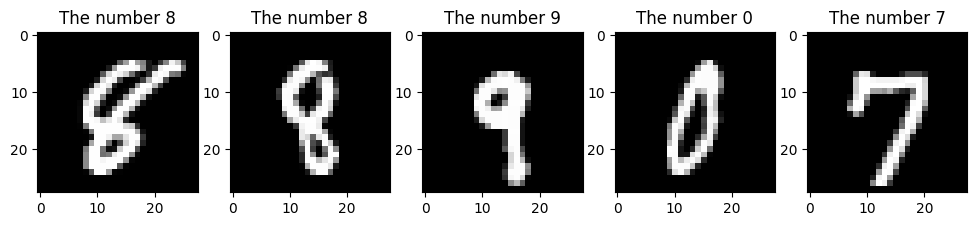

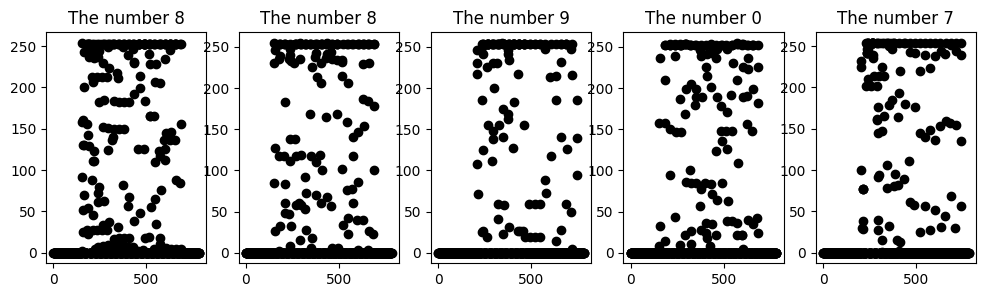

In [39]:
# get 5 random indices and show the corresponding images
indices = np.random.choice(np.arange(data.shape[0]), 5)
show_digit_pic(indices, data, labels)
digit_in_fnn_vision(indices, data, labels)

### normalize and organize data

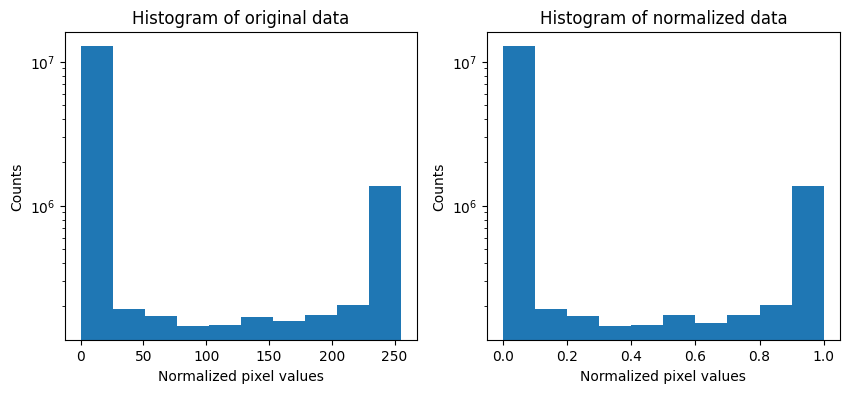

In [40]:
# normalize data
dataNorm = data / np.max(data)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].hist(data.flatten())
ax[0].set_xlabel("Normalized pixel values")
ax[0].set_ylabel("Counts")
ax[0].set_title("Histogram of original data")
ax[1].hist(dataNorm.flatten())
ax[1].set_xlabel("Normalized pixel values")
ax[1].set_ylabel("Counts")
ax[1].set_title("Histogram of normalized data")
ax[0].set_yscale('log')
ax[1].set_yscale('log')
plt.show()

In [41]:
# convert to tensor
dataTensor = torch.tensor(dataNorm, dtype=torch.float)
labelsTensor = torch.tensor(labels, dtype=torch.long)

# split into training and test set
train_data, test_data, train_labels, test_labels = train_test_split(
    dataTensor, labelsTensor, test_size=0.2, random_state=42
)

# convert to torch dataset and to dataloader
train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True)

print("Number of training samples: %i" % len(train_dataset))
print("Number of test samples: %i" % len(test_dataset))
print("Number of batches: %i" % len(train_loader))
print("Shape of one batch: %s" % str(next(iter(train_loader))[0].shape))

Number of training samples: 16000
Number of test samples: 4000
Number of batches: 500
Shape of one batch: torch.Size([32, 784])


### ANN model

In [51]:
class ANN(nn.Module):
    def __init__(self):
        super().__init__()
        self.input = nn.Linear(784, 128)
        self.hidden1 = nn.Linear(128, 64)
        self.hidden2 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 10)
        self.norm128 = nn.BatchNorm1d(128)
        self.norm264 = nn.BatchNorm1d(64)
        self.norm232 = nn.BatchNorm1d(32)
        self.dr = 0.5

    def forward(self, x):
        x = F.relu(self.input(x))
        x = self.norm128(x)
        x = F.dropout(x, p=self.dr, training=self.training)
        x = F.relu(self.hidden1(x))
        x = self.norm264(x)
        x = F.dropout(x, p=self.dr, training=self.training)
        x = F.relu(self.hidden2(x))
        x = self.norm232(x)
        x = F.dropout(x, p=self.dr, training=self.training)
        x = F.log_softmax(self.output(x), dim=1)
        return x

In [52]:
def create_model():

    model = ANN()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.NLLLoss()
    return model, optimizer, criterion

In [54]:
# test
model, optimizer, criterion = create_model()
data = torch.randn(32, 784)
output = model(data)
print(model)
print(output)
print(output.shape)


ANN(
  (input): Linear(in_features=784, out_features=128, bias=True)
  (hidden1): Linear(in_features=128, out_features=64, bias=True)
  (hidden2): Linear(in_features=64, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=10, bias=True)
  (norm128): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm264): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm232): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
tensor([[-1.9479, -3.9532, -2.3039, -2.7880, -3.2693, -1.5446, -3.8574, -1.6752,
         -2.9330, -1.8093],
        [-4.1157, -3.4102, -3.3828, -1.3834, -1.3179, -3.4622, -2.3228, -3.8409,
         -2.0310, -2.1519],
        [-3.8580, -2.7036, -1.6975, -1.5650, -2.2361, -1.5900, -2.7341, -2.9483,
         -3.5319, -2.7763],
        [-2.6566, -1.7626, -2.7656, -1.7863, -1.7503, -2.8416, -2.5764, -3.3548,
         -2.2289, -2.5635],
        [-1.4020, -1.

### train model function

In [55]:
def train_model(train_loader, test_loader):
    epochs = 100
    model, optimizer, criterion = create_model()
    losses = np.zeros(epochs)
    trainAcc = np.zeros(epochs)
    testAcc = np.zeros(epochs)

    for i in range(epochs):
        model.train()
        batchAcc = []
        bactchLoss = []
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            batchAcc.append(
                100 * torch.mean((labels == torch.argmax(outputs, dim=1)).float())
            )
            bactchLoss.append(loss.item())
        losses[i] = np.mean(bactchLoss)
        trainAcc[i] = np.mean(batchAcc)

        # test model
        model.eval()
        x, y = next(iter(test_loader))
        with torch.no_grad():
            outputs = model(x)
            testAcc[i] = 100 * torch.mean((y == torch.argmax(outputs, dim=1)).float())
        sys.stdout.write("\r" + f"Epooch {i+1}/{epochs} loss: {losses[i]:.2f} trainAcc: {trainAcc[i]:.2f}")

    return model, losses, trainAcc, testAcc

### test the model

In [56]:
model, losses, trainAcc, testAcc = train_model(train_loader, test_loader)

Epooch 100/100 loss: 0.23 trainAcc: 93.61

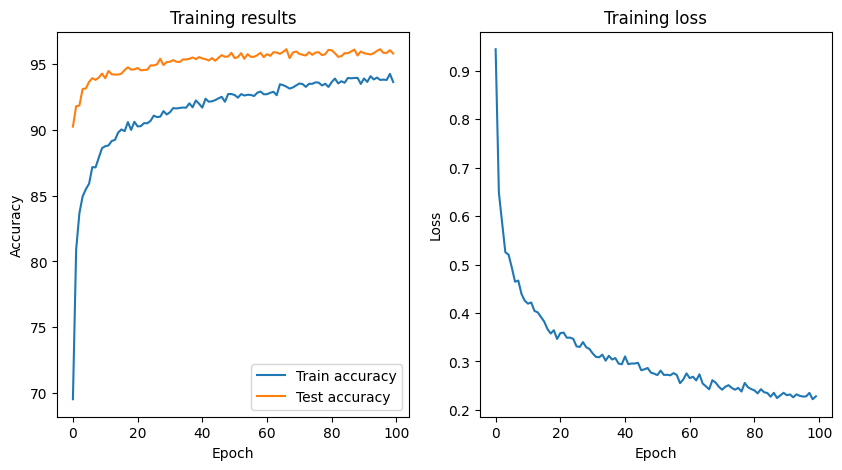

In [57]:
# plot
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(trainAcc, label="Train accuracy")
plt.plot(testAcc, label="Test accuracy")
plt.legend()
plt.title("Training results")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.subplot(1, 2, 2)
plt.plot(losses)
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

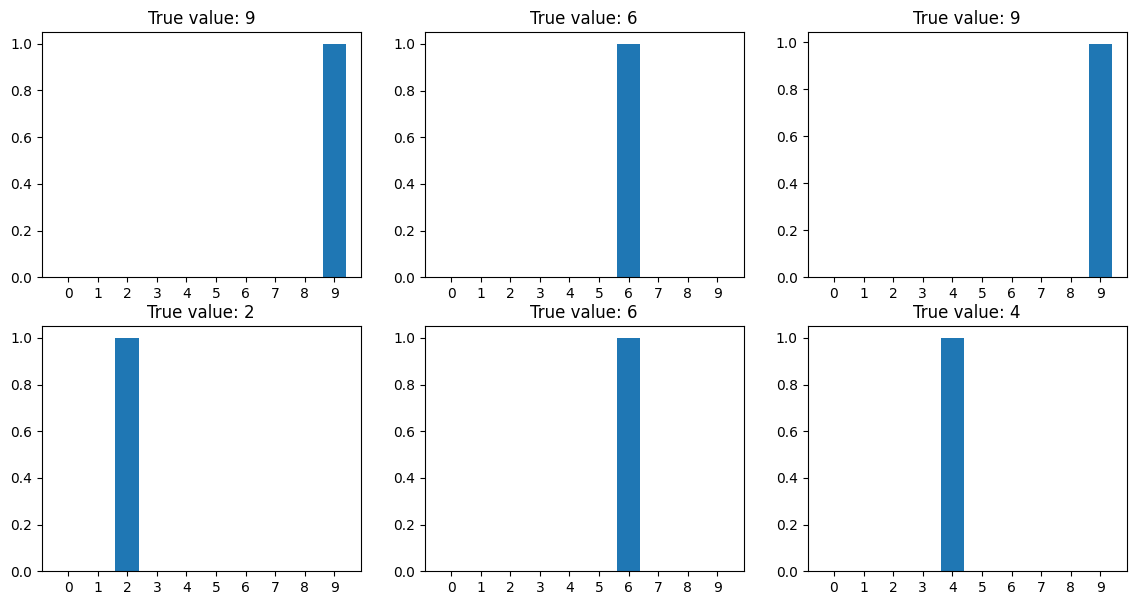

In [77]:
# plot some sample
random_indexs = np.random.randint(0, len(test_dataset), 6)
x, y = test_dataset[random_indexs]
prediction = model(x).detach()

plt.figure(figsize=(14, 7))
for i, pred in enumerate(prediction):
    plt.subplot(2, 3, i + 1)
    plt.bar(range(10), torch.exp(pred))
    plt.xticks(np.arange(10))
    plt.title(f"True value: {y[i]}")
plt.show()

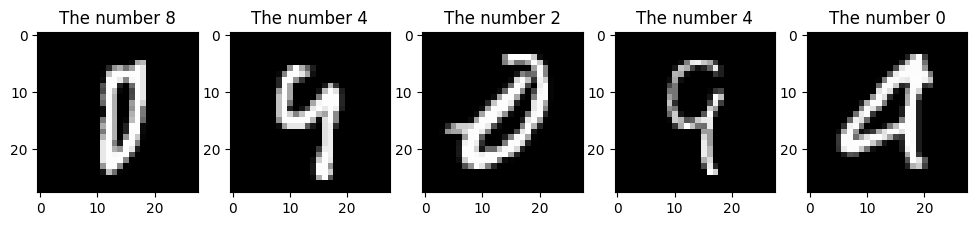

In [78]:
# plot the error values
x, y = next(iter(test_loader))
yhat = model(x).detach()
prediction = torch.argmax(torch.exp(yhat), dim=1)
missed_index = np.array(np.where(prediction != y))[0]
missed_index = np.random.choice(missed_index, 5)
show_digit_pic(missed_index, x, prediction)


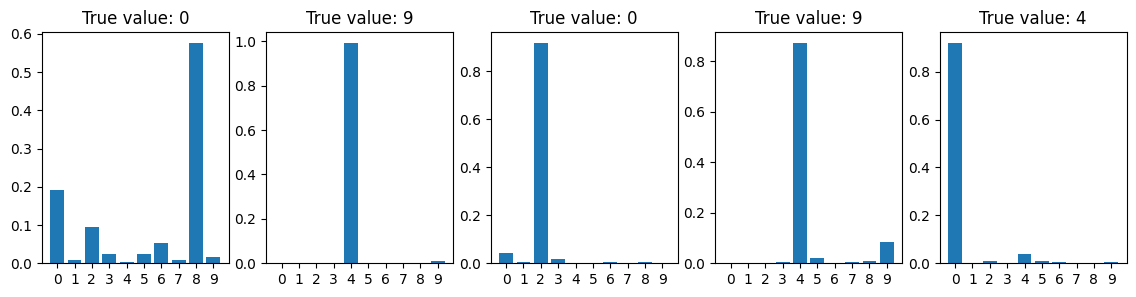

In [86]:
plt.figure(figsize=(14, 3))
for i, pred in enumerate(missed_index):
    plt.subplot(1, 5, i + 1)
    plt.bar(range(10), torch.exp(yhat[pred]))
    plt.xticks(np.arange(10))
    plt.title(f"True value: {y[pred]}")
plt.show()